# **Needed Libraries**


In [48]:
# Data science 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Single cell 
import scanpy as sc
import anndata as ad
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# Output control
import warnings
warnings.filterwarnings("ignore")

# **Why scanpy?**


Given that the data comprises single-cell synthetic datasets, we utilize the `scanpy` Python library for its extensive set of functionalities and tools specifically designed for the preprocessing and dimensionality reduction tasks in the assignment for single cell data. In terms of dimensionality reduction, `scanpy` offers a wider range of options, including PCA, UMAP, and TSNE, while other libraries like sci-kit learn, for instance, only provide PCA and TSNE. Additionally, `scanpy` makes use of `anndata` for data handling, a Python package that creates annotated data matrices, proving to be highly beneficial during the preprocessing stage.


# **A note on our Approach**

Instead of constructing a single automated processing pipeline immidiently, that encompasses:

- Preprocessing
- Dimensionality reductiond
- Clustering
- Visualization of the results

We adopt a more explainable approach. Our strategy involves showcasing the reasoning behind each step and iteratively building the pipeline, ultimately combining all the components in an automated manner. To ensure clarity in representation, we will initially utilize only one of the five datasets. However, upon completing the pipeline explanation, we will build and run it on all five datasets for a comprehensive analysis.

For better implementation, we have organized the majority of utility functions, especially for plotting, in separate files. This approach helps reduce clutter in the notebook and enhances code readability and maintainability. Of course each of the functions utilized is explained before utilized.


---


# **Stage 1: Preprocessing**


First of all we load the dataset we will use to demonstrate each step of the pipeline, `sc.read_csv` loads it in an AnnData object, where `n_obs` correspond to the number of cells and `n_vars` to the number of genes.


In [49]:
adata = sc.read_csv("datasets/dataset4.csv")
adata

AnnData object with n_obs × n_vars = 200 × 200

## _1. Quality Control_


To quickly retrieve data that can be utilized for QC, we run `scanpy`'s `calculate_qc_metrics`. It retuerns:

- For cells (obs):
  - n_genes_by_counts $\rightarrow$ The number of genes that were expressed in each cell
  - total_counts $\rightarrow$ The total expression level measured in each cell
  - log1p >> $\rightarrow$ Corresponds to the above information, but log transformed to reduce the impact of extremely high or low expression values
- For genes (var):
  - n_cells_by_counts $\rightarrow$ The number of cells in which each gene is expressed
  - total_counts $\rightarrow$ The total expression level of each gene across all cells
  - mean_counts $\rightarrow$ Represents the average expression level of each gene across all cells
  - log1p >> $\rightarrow$ Corresponds to the above information, but log transformed to reduce the impact of extremely high or low expression values
  - pct_dropout_by_counts $\rightarrow$ The percentage of cells in which each gene is not detected or expressed


In [50]:
sc.pp.calculate_qc_metrics(adata,percent_top = None,log1p = True,inplace = True)
adata

AnnData object with n_obs × n_vars = 200 × 200
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

We utilize a plotting function we coded from `plottingutils.py` which creates a subplot of two histograms to showcase the distributions:

- Of the number of genes that were expressed in each cell and their total cell expression levels. Along with their median values.


In [51]:
from utils.plotting import hist_subplot

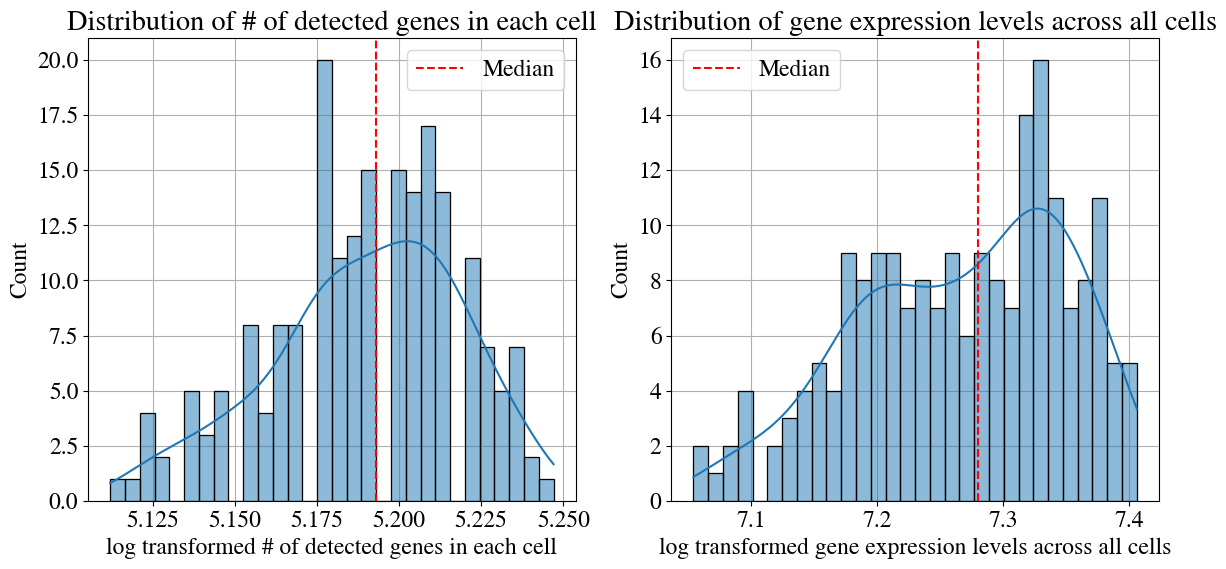

In [52]:
hist_subplot(data1 = adata.obs["log1p_n_genes_by_counts"],
             data2 = adata.obs["log1p_total_counts"],
             xlabel1= "log transformed # of detected genes in each cell",
             xlabel2 = "log transformed gene expression levels across all cells",
             title1="Distribution of # of detected genes in each cell",
             title2= "Distribution of gene expression levels across all cells",
             plot_median=True)

Having the above distributions in mind we can facilitate qulity control via cell filtering:

- For cell filtering it is recommended to employ moderately lenient thresholds, such as 5 median absolute deviations (MADs) to 3 MADs in at least 2 distributions, this approach allows the exclusion of low-quality cells without introducing bias against certain subpopulations. [[Germain et al., 2020]]([Link](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02136-7#Sec16))
  $$ MAD = median(|X_i - median(X)|)$$


In [53]:
def mad(qc_metric):
    """Function that returns the median absolute deviation for a QC metric"""
    return np.median(np.abs(qc_metric - np.median(qc_metric)))

Regarding gene filtering we can safely remove genes that have $0$ expression across all cells. Optinally set a cut-off such as genes expressed in less than $5\%$ of all the cells. However it is not really needed, since dimensionality reduction techniques such as PCA will reduce the dimensions of the gene expression data while retaining the most of the variance.

It is important to emphasize that there is no universally applicable criterion for cell and gene filtering. Therefore, the outcomes of various quality control thresholds should be assessed at the final stage of the pipeline.


### _Cell filtering_

We utilize a function called `cell_filtering` to effectively filter cells based on the user-defined number of absolute deviations away from the median, which is determined by the `mads_away` parameter. The default value is set to $5$, as previously discussed for lenient theshold. More specifically, if a cell deviates from the median by the specified number of MADs in both the distribution of total gene expression per cell and the number of detected genes per cell, it does not carry valuable information since it either has very few genes expressed with very low expression or the exact opposite and is flagged for filtering via a boolean mask the function returns.


In [54]:
def cell_filtering(M1,M2,mads_away = 5):
  """Returns a boolean mask with the value of True for cells that will be filtered, 
  since they are sufficient MADs away from the median in both the distribution of M1, M2 QC metrics"""
  mask = (M1 < np.median(M1) - mads_away * mad(M1)) | (M1 > np.median(M1) + mads_away * mad(M1) ) &\
  (M2 < np.median(M2) - mads_away * mad(M2)) | (M2 > np.median(M2) + mads_away)
  return mask                                  

In [55]:
mask = cell_filtering(adata.obs["log1p_n_genes_by_counts"],adata.obs["log1p_total_counts"],mads_away=5)
adata = adata[~mask]
adata

View of AnnData object with n_obs × n_vars = 200 × 200
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### _Gene filtering_

For gene filtering, we implement a function called `gene_filtering` that effectively eliminates genes that show no expression across all cells since they will affect the average during the normalization step. We dont utilize additional complex methods, due the small feature size (in the context of single cell data) of our data set & the dimensionality reduction techniques we will implement in a later stage which are able to preserve most of the important gene expression information in lower dimensions.


In [56]:
def gene_filtering(M):
  """Returns a boolean mask with the value of True for genes that will be filtered, 
  since they are not expressed in any cell"""
  mask = (M == 0) 
  return mask

As you can see all genes pass this criterion


In [57]:
mask = gene_filtering(adata.var["n_cells_by_counts"])
adata.var_names = adata.var_names[~mask]
adata

AnnData object with n_obs × n_vars = 200 × 200
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## _2. Normalization_

The next step of the preprocessing stage of the pipeline is the normalization and log transformation of the dataset, many dimensionality reduction and clustering downstream methods are sensitive to the scaling of the data, additionally many statistical methods assume data with uniform variance structure. For this reason we:

- Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization via the `normalize_total` preprocessing `scanpy` method
- Log transform the counts matrix to stabilize the variance


In [58]:
adata_unormalized = adata.copy()
# Normalization
sc.pp.normalize_total(adata, target_sum=None, inplace=True)
# log1p transform
adata.X = sc.pp.log1p(adata.X)

You can see how the distribution of the gene expression levels for all cells is "squashed" and approximates better a normal distribution.


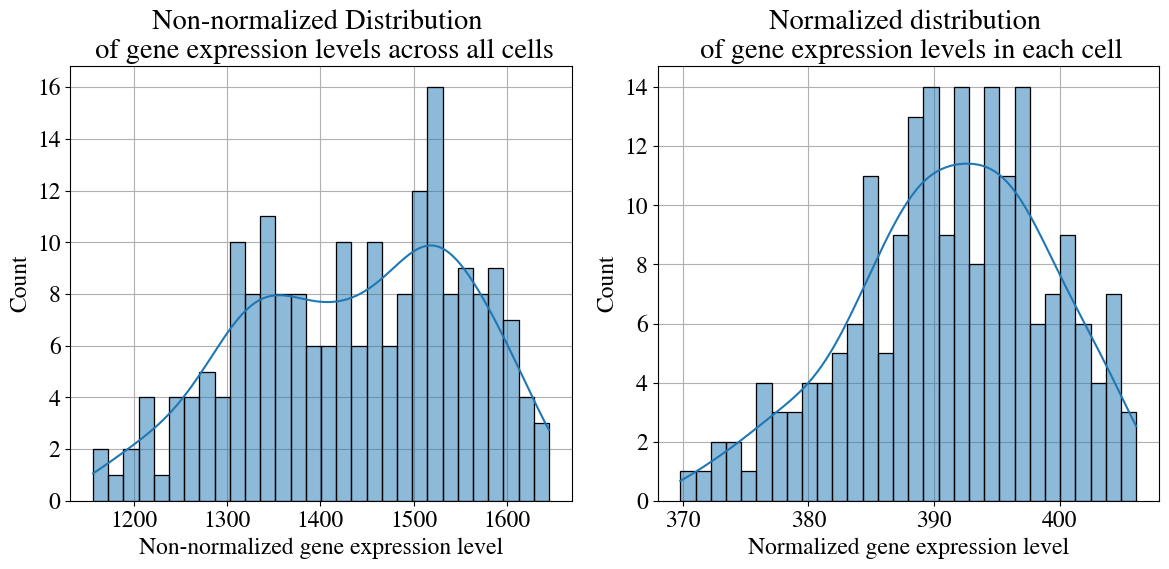

In [59]:
hist_subplot(data1 = adata_unormalized.X.sum(axis=1),
             data2 = adata.X.sum(axis=1),
             xlabel1 = "Non-normalized gene expression level",
             xlabel2 = "Normalized gene expression level",
             title1 = "Non-normalized Distribution \n of gene expression levels across all cells",
             title2 = "Normalized distribution \n of gene expression levels in each cell"
             )

## _3. Feature Selection_ (optional)


Having followed best practices, the subsequent and final step of the preprocessing stage is feature selection, by identifying highly variable genes. However, considering the limited size of our datasets, containing only 200 genes each, we believe that conducting feature selection may not be essential and could potentially introduce bias due to the reduced sample size. Consequently, when developing the automated pipeline, we will make this step **optional**.


The scanpy `highly_variable_genes` method, allows for a quick feature selection utilizing the following parameters:

- `min_mean`: The minimum mean expression threshold for genes to be considered. Genes with low mean expression values below this threshold are excluded from the analysis.
- `max_mean`: The maximum mean expression threshold for genes to be considered. Genes with high mean expression values above this threshold are excluded from the analysis.
- `min_disp`: The minimum gene dispersion threshold. Gene dispersion measures the extent of variation in gene expression across cells and genes with lower dispersion than the threshold are removed from the analysis.


In [60]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.var['highly_variable'].value_counts()

False    133
True      67
Name: highly_variable, dtype: int64

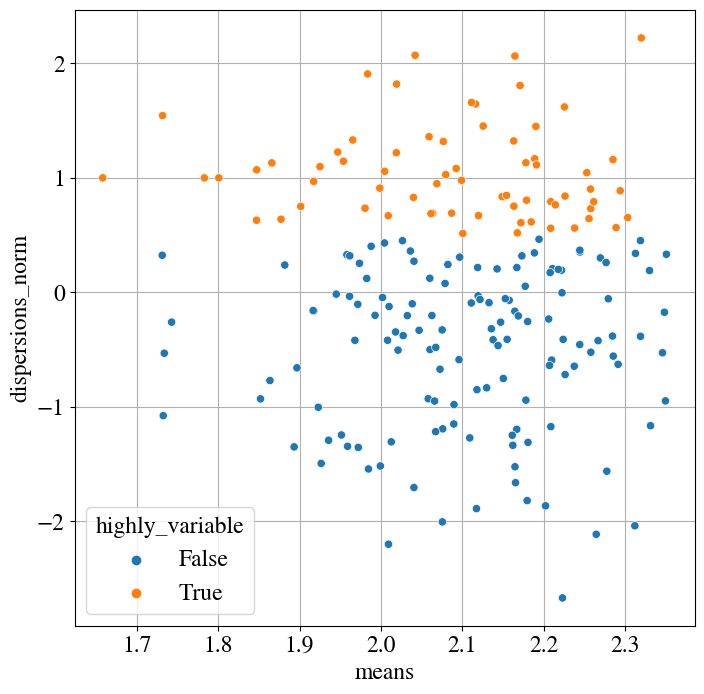

In [61]:
plt.figure(figsize=(8,8))
sns.scatterplot(data = adata.var,x = 'means', y =  'dispersions_norm',hue = 'highly_variable')
plt.grid()

Having finished with preprocessing we save the transformed dataset along with its annotations:


In [62]:
adata.write("processed_datasets/dataset4.h5ad")

---
